In [1]:
import numpy as np
from numpy.random import default_rng 
from joblib import Parallel, delayed
import scipy.integrate as spi
import matplotlib.pyplot as plt

In [2]:
def init_w_array():
    """
    This function initializes the w array
    """
    w_min  = -20.0
    w_max  =  20.0
    wp_min = -30.0
    wp_max =  30.0

    #how many samples in each direction?
    n_w  = 1001
    n_wp = 1001

    #produce arrays of w, w'
    w = np.linspace(w_min,w_max,n_w)
    wp = np.linspace(wp_min, wp_max, n_wp)

    return w, wp, n_w, n_wp

In [3]:
def plot_w_wp(table):
    fig = plt.figure(figsize=(7,7))
    plt.imshow(np.log(table),extent=[-10,10,-30,30],origin="lower")
    plt.gca().set_aspect(0.3333)
    plt.xlabel(r'$w$')
    plt.ylabel(r"$w'$")

(1001, 1001)


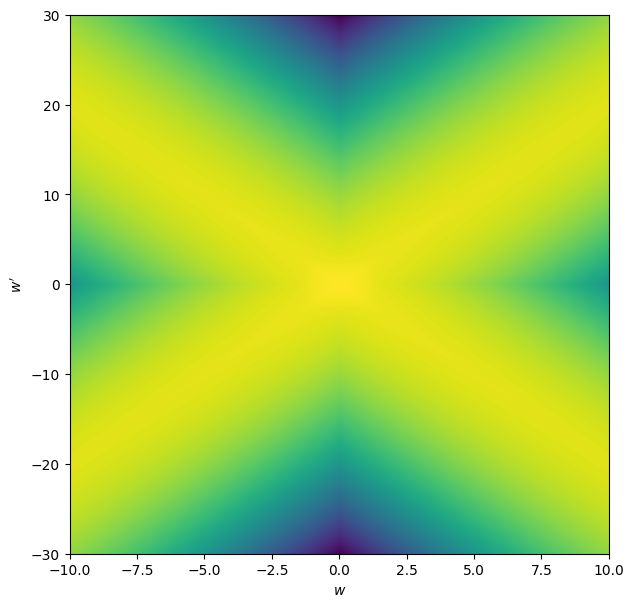

In [4]:
def make_rw_table():
    """
    This function creates the table for the R(w,w') function
    """
    def r_w_w_prime(x, w, w_prime):
        """
        Defining the R(w,w') function
        """
        J = (np.pi)**(-3.5)

        T_eff = (10/10**4)**(-0.5)
        a = 4.7e-4 * T_eff 
        w_lower = np.min(np.array([np.abs(w), np.abs(w_prime)]))
        w_upper = np.max(np.array([np.abs(w), np.abs(w_prime)]))
        return J * (np.exp(-x**2)) * ((np.arctan((w_lower+x)/a)) - (np.arctan((w_upper-x)/a)))

    def integrate_r_w_w_prime(i, j, wx, wpy):
        w_1 = wx[i, j]
        w_prime_1 = wpy[i, j]
        w_lower = np.min(np.asarray([np.abs(w_1), np.abs(w_prime_1)]))
        w_upper = np.max(np.asarray([np.abs(w_1), np.abs(w_prime_1)]))
        l_lim = 0.5 * np.abs(w_upper - w_lower)
        int_result, err = spi.quad(r_w_w_prime, l_lim, np.inf, args=(w_1, w_prime_1))
        return i, j, int_result

    w, wp, n_w, n_wp = init_w_array()
    wx, wpy = np.meshgrid(w, wp)

    # Prepare for parallel computation
    n_jobs = -1  # Use all available CPUs
    result_mesh = np.zeros(wx.shape)

    # Perform parallel computation
    results = Parallel(n_jobs=n_jobs)(delayed(integrate_r_w_w_prime)(i, j, wx, wpy) for i in range(wx.shape[0]) for j in range(wx.shape[1]))

    # Fill in the result mesh with computed values
    for i, j, res in results:
        result_mesh[i, j] = res

    np.savetxt('int_table.txt', result_mesh)

    return result_mesh

Rwwp = make_rw_table()

print(Rwwp.shape)

plot_w_wp(Rwwp)

In [5]:
# Modify Rwwp
w, wp, n_w, n_wp = init_w_array()
w[900]

16.0

In [6]:
# # Modify Rwwp
# w, wp, n_w, n_wp = init_w_array()

# k,d = 900,1100
# # Modifying the R(w,w') function between w = 2 and w' = -2
# Rwwp[k:d, k:d] = 10e-6

# plot_w_wp(Rwwp)


PDF of w' direction is saved as Rwwp_normalized.txt


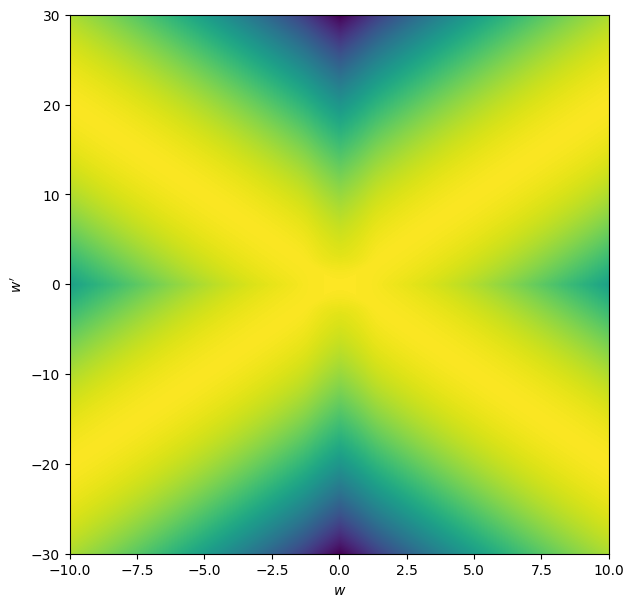

In [7]:
def get_pdf(Rwwp):
    """
    This function takes the Rwwp matrix and returns the PDF of the w' direction
    """

    Rwwp_norm = Rwwp.copy()
    for i in range(len(Rwwp[0])):

        k = spi.trapezoid(Rwwp[:,i],dx=0.06)

        Rwwp_norm[:,i] = Rwwp_norm[:,i]/k # Normalize the Rwwp in the w' direction

    np.savetxt('Rwwp_normalized.txt', Rwwp)

    print('PDF of w\' direction is saved as Rwwp_normalized.txt')

    return Rwwp_norm

Rwwp_norm = get_pdf(Rwwp)
plot_w_wp(Rwwp_norm)

CDF of w' direction is saved as Rwwp_cdf.txt


Text(0, 0.5, "$w'$")

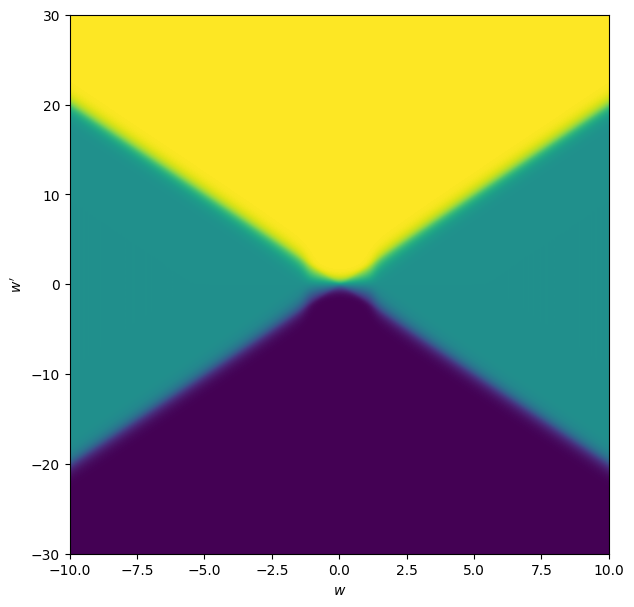

In [8]:
def get_cdf(R_N):
    """
    This function takes the R_N matrix and returns the CDF of the w' direction
    """
    w, wp, n_w, n_wp = init_w_array()

    Rwwp = R_N
    Rint = np.zeros_like(Rwwp)

    for i in range(n_w):
        for j in range(1,n_wp):
            Rint[j,i] = 0.5*(Rwwp[j-1,i] + Rwwp[j,i])*(wp[j]-wp[j-1]) + Rint[j-1,i] 

    # Save cdf
    np.savetxt('Rwwp_cdf.txt',Rint)

    print('CDF of w\' direction is saved as Rwwp_cdf.txt')

    return Rint

Rwwp_cdf = get_cdf(Rwwp_norm)

fig = plt.figure(figsize=(7,7))
plt.imshow(Rwwp_cdf,extent=[-10,10,-30,30],origin="lower")
plt.gca().set_aspect(0.33333)
plt.xlabel(r'$w$')
plt.ylabel(r"$w'$")



In [9]:
def random_theta_phi(phot_num=0, scat_num=0, n=100000):
    """
    Generate random theta and phi values.
    
    Returns:
    tuple: theta and phi values in radians.
    """
    seed = abs(hash((phot_num, scat_num, "theta_phi")))  # Using hash function with unique identifiers
    #print(f'Random Direction: using seed {seed}')
    rng = default_rng(seed)
    eta_1 = rng.uniform(0, 1, n)
    eta_0 = rng.uniform(0, 1, n)
    theta = np.arccos(2 * eta_0- 1)
    phi = 2 * np.pi * eta_1

    return theta, phi

def random_tau(phot_num=0, scat_num=0, n=100000):
    """
    Generate random optical depth for the particle to move
    
    Returns:    
        float: optical depth
        
    """
    seed = abs(hash((phot_num, scat_num, "tau")))  # Using hash function with unique identifiers
    #print(f'Random tau: using seed {seed}')
    rng = default_rng(seed)
    eta_1 = rng.uniform(0, 1, n)
    tau = -np.log(1 - eta_1)

    return tau

def get_tau_h(w,tau_0=(10**4)):
    """
    This function takes the frequency w and the optical depth tau_0 and returns the integrated optical depth tau_int
    """
    a = 4.7e-4 * (10/10**4)**(-0.5)

    def get_H_w_a(w,a):
        H_0 = np.exp(-w**2)
        K_w = (1/(2*w**2))*(H_0 * (4*w**2+3) * (w**2+1) - w**(-2)*(2*w**2+3)*np.sinh(w**2))
        return H_0* (1 - (2*a/np.sqrt(np.pi))*K_w)
    

    if w == 0:
        w = 10**-9

    
    tau_int = tau_0 * get_H_w_a(w,a)/get_H_w_a(10**-9,a)

    return tau_int

In [10]:
def get_wp_from_random_variate(xi_p,phot_num=0,scat_num=0,Rint=None,wc=1,):

    """
    This function takes the random variate xi_p and returns the corresponding w'

    Args:
    -----
    phot_num (int): The photon number
    scat_num (int): The scatter number
    Rint (np.array): The table of R(w,w') values
    wc (float): The current w value

    Returns:
    float: w'
    """
    
    if Rint is None:
        Rint = np.loadtxt('Rwwp_cdf.txt')
    

    #make our array of output wp values
    w, wp, n_w, n_wp = init_w_array()

    #find the w indices bounding current w
    wi = np.searchsorted(w,wc,side="left")
    
    #define i, i+1
    i   = wi-1
    ip1 = wi
    
    #embed()
    #find the wp indices bounding xi_p
    
    wpi  = np.searchsorted(Rint[:,i],xi_p[scat_num])
    wpia = np.searchsorted(Rint[:,ip1],xi_p[scat_num])

    #define j, j+1 for each w
    j  = wpi-1
    ja = wpia-1
    
    #ensure the bounding box is large enough
    if(j>ja):
        ja = j
    elif(j<ja):
        j = ja
        
    jp1 = j+1
    #embed()
    #define t, z0, z1, z2, z3, and z
    t = (wc - w[i])/(w[ip1]-w[i])
    z0 = Rint[j,i]
    z1 = Rint[jp1,i]
    z2 = Rint[j,ip1]
    z3 = Rint[jp1,ip1]
    
    #find u
    u = (xi_p[scat_num] - z2*t - z0*(1.-t))/((z1-z0)*(1.-t) + (z3-z2)*t)
    
    #get wp
    wpc = u*(wp[jp1] - wp[j]) + wp[j]

    return wpc


In [11]:
def write_results_to_file(phot_num, scat_num, escape_w):
    # First, create and open the text file for writing. Choose a name: 
    filename = 'results.txt'
    
    # Open the file in append mode
    outfile = open(filename, 'a')

    # Prepare the data string
    dataString = f'{phot_num},{scat_num},{escape_w}'

    # Write the data string to the file
    outfile.write(dataString + '\n')

    # Don't forget to close the file when you're done
    outfile.close()

In [12]:
# Constants
MAX_NUM_SCAT = 1000000
ESCAPED_PHOTONS_THRESHOLD = 1000
escaped_w = []

theta_vals, phi_vals = random_theta_phi()
tau_vals = random_tau()

seed = 133  # Using hash function with unique identifiers

rng = default_rng(seed)
n_rand = 100000

#get the xi_p
xi_p = rng.uniform(0,1,n_rand)

def simulate_photon():
    escaped_photons = 0
    scat_num = 0
    w, x = 0, 0
    phot_num = 0

    while escaped_photons < ESCAPED_PHOTONS_THRESHOLD:
        for _ in range(MAX_NUM_SCAT):
            # Get tau_h for the current w
            tau_h_in = get_tau_h(w)

            # Get random direction
            theta, phi = theta_vals[scat_num], phi_vals[scat_num]

            # Get random tau for how far the photon will travel
            tau = tau_vals[scat_num]
            tau_eff = tau * np.sin(theta) * np.cos(phi)

            # Get distance traveled in the x direction
            del_x = tau_eff / tau_h_in

            new_x = x + del_x
            
            #print(f'Photon {phot_num} scattered {scat_num} times. New x = {new_x}')
            if np.abs(new_x) > 1:
                #print(f'Photon {phot_num} escaped at scatter {scat_num} at w = {w}')
                escaped_photons += 1
                escaped_w.append(w)
                w = 0
                scat_num = 0
                phot_num += 1
                
                break
            else:
                w = get_wp_from_random_variate(xi_p,phot_num,scat_num,wc=w)
                x = new_x
                scat_num += 1






In [13]:
simulate_photon()

In [ ]:
print(len(escaped_w))

In [ ]:
w = np.linspace(-20,20,1000)

def J(w):
    """
    Calculate the J(w) function in order to calculate the P(w) function solution
    """
    a = 4.7e-4 * (10/10**4)**(-0.5)
    tau0 = 10**4
    return np.sqrt(6) / (24 * np.sqrt(np.pi * a * tau0)) * w**2 / np.cosh(np.pi**3 * w**3 / (54 * a * tau0))

P_w = J(w)/spi.trapezoid(J(w),dx=0.04)

plt.hist(escaped_w, bins=20,density=True)
plt.plot(w,P_w,'orange')
plt.show()
